# Paper Images

In [30]:
import os
import re
import csv
import sys
import json
import string
import xml.etree.ElementTree as ET
import nltk
nltk.download('words')
from nltk import sent_tokenize
from nltk.corpus import words
from IPython.display import Image
import random
import numpy as np
from termcolor import colored

from IPython.display import HTML as html_print
from IPython.display import Markdown

import cv2
import pandas as pd

import nltk
from nltk import agreement
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from collections import Counter
from scipy.stats import pearsonr
from sklearn.metrics import cohen_kappa_score

from matplotlib import pyplot as plt
%pylab inline
import seaborn as sns
sns.set(color_codes=True)
sns.set_style("ticks")

SPELLCHECKER_WORDS = set(words.words())
DEBUG = False

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package words to
[nltk_data]     /nas/home/telinwu/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Generals

In [5]:
# qualtric ids
def get_qualt_ids(start_block=1, end_block=24):
    start_block += 1
    end_block += 2
    start_block = max(2, start_block)
    end_block = min(26, end_block)
    qualt_ids = []
    for block in range(start_block, end_block):
        for ques_idx in range(1, 31):
            qualt_id = "{}_Q{}".format(ques_idx, block)
            qualt_ids.append(qualt_id)
    return qualt_ids

In [174]:
from macros import *

DICT_STRS = {
    "choice": "1. choice",
    "conf": "2. confidence",
    "others": "3. others agreement",
    "com": "4. if common sense",
    "edu": "5. education level",
    "clearness": "6. clearness",
    "cat": "7. category",
}

### Processed Dicts (JSON)

In [15]:
mcq_dict_f = "../outputs/piqa_qualt_sorted_dict.json"
bin_dict_f = "../outputs/binpiqa_qualt_sorted_dict.json"
mcq_qualt_dict = json.load(open(mcq_dict_f, "r"))
bin_qualt_dict = json.load(open(bin_dict_f, "r"))
qualt_dicts = (mcq_qualt_dict, bin_qualt_dict)

## Pie Charts

In [231]:
# functions
def draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", start_block=1, end_block=24, figsize=(8,8), save_str=None):
    assert mode in ["edu", "cat", "clearness"]
    mcq_qualt_dict, bin_qualt_dict = qualt_dicts
    qualt_ids = get_qualt_ids(start_block=start_block, end_block=end_block)
    
    curr_cat_name = CAT_NAMES[mode]
    qualt_type = DICT_STRS[mode]
    curr_id_dict = CAT_ID_DICTS[mode]
    print ("{}: {}".format(curr_cat_name, qualt_type))
    
    res = []
    
    for qualt_id in qualt_ids:
        mcq_annots = mcq_qualt_dict[qualt_id]["annotations"]
        bin_annots = bin_qualt_dict[qualt_id]["annotations"]
        mcq_cat = mcq_annots[qualt_type]
        bin_cat = bin_annots[qualt_type]
        
        # current logic, have it as long as >= 2 agreed
        if mode in ["edu", "clearness"]:
            joint_cat = mcq_cat + bin_cat
        elif mode in ["cat"]:
            joint_cat = []
            for each in mcq_cat:
                joint_cat += each
            for each in bin_cat:
                joint_cat += each            
        else:
            raise ValueError("No such categorical data: {}".format(mode))
        joint_counter = Counter(joint_cat)
        for ele, cnt in joint_counter.items():
            if cnt > 2:
                res.append(ele)
                
    res_counter = Counter(res)
    labels = []
    sizes = []
    for id_ in sorted(curr_id_dict):
        id_str = curr_id_dict[id_]
        if id_ in res_counter:
            id_cnt = res_counter[id_]
            labels.append(id_str)
            sizes.append(id_cnt)
        else:
            id_cnt = 0
        print ("{}: {}".format(id_str, id_cnt))

        
    # Pie chart
    #colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', 'violet', 'lightgray']
    
    #explsion
    explode = [0.02] * len(labels)
    
    fig1, ax1 = plt.subplots(figsize=figsize)
    wedges, texts, autotexts = ax1.pie(sizes, colors = colors,
                                       # labels=labels,
                                       autopct='%1.1f%%',
                                       startangle=90, pctdistance=0.75,
                                       wedgeprops=dict(width=0.5),
                                       shadow=False,
                                       explode=explode)
    
    
    """
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    """
    
    ax1.legend(wedges, labels,
               title=curr_cat_name,
               loc="center left",
               fontsize=14,
               bbox_to_anchor=(0.9, 0, 0.3, 0.5))
        
    plt.setp(autotexts, **{'weight':'bold', 'fontsize':14})
    
    #draw circle
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    # ax1.set_title(curr_cat_name, fontsize=18)
    plt.tight_layout()
    plt.show()
    
    if save_str is not None:
        fig1.savefig(save_str, bbox_inch='tight')
            
    return None

### Educational Levels

Educational Levels: 5. education level
Most 10 year olds: 225
Not most 10 year olds: 329
Only domain experts: 112
No one: 0
Not sure: 35


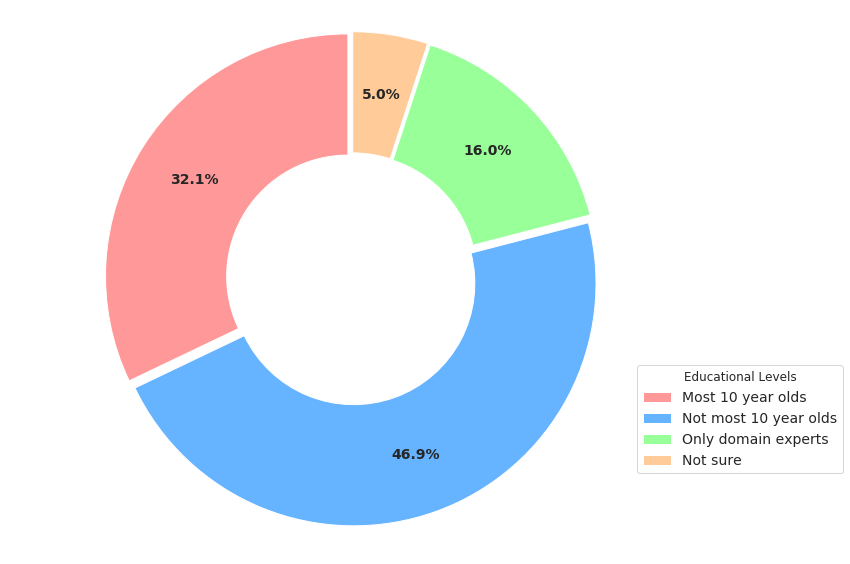

In [232]:
save_str = "imgs/edu_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="edu", end_block=24, figsize=(12,8), save_str=save_str)

### Categories

Physical Common Sense Categories: 7. category
Typical Functions: 256
Affordances: 175
Spatial Relationships: 45
Definitional Attributes: 161
Everyday Knowledge: 270
None of the above: 174


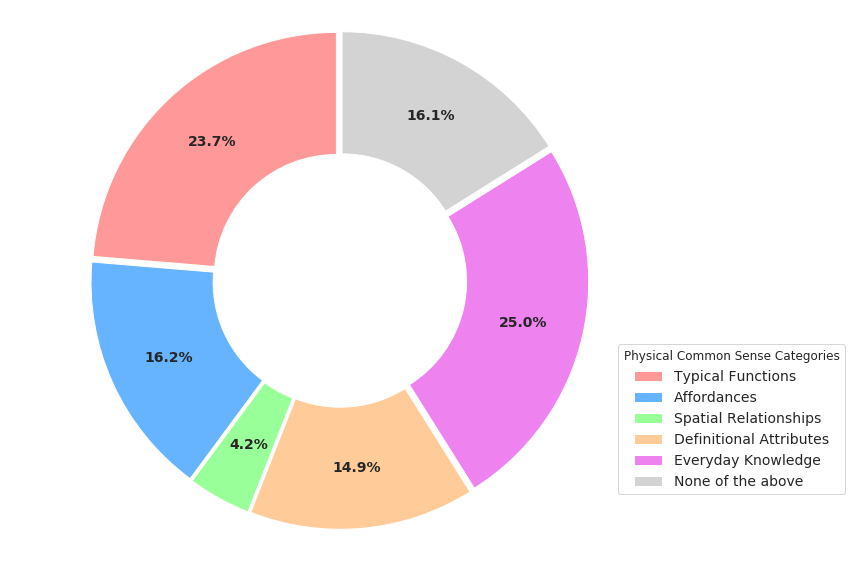

In [233]:
save_str = "imgs/cat_pie_charts.pdf"
draw_pie_charts_for_cat_data(qualt_dicts, mode="cat", end_block=24, figsize=(12,8), save_str=save_str)